# Privacy protection control for mobile apps users

# Reproducing Artifacts

This computational document provides thorough information and codes to reproduce the experiments of the associated paper *Privacy protection control for mobile apps users*.

**Authors**
- Sophie Cerf*, Univ. Lille, Inria, CNRS, Centrale Lille, UMR 9189 CRIStAL, Lille, F-59000, France
- Bogdan Robu, Univ. Grenoble Alpes, CNRS, Grenoble INP, GIPSA-lab, Grenoble, 38000, France
- Nicolas Marchand, Univ. Grenoble Alpes, CNRS, Grenoble INP, GIPSA-lab, Grenoble, 38000, France
- Sara Bouchenak, INSA Lyon - LIRIS - CNRS, Distributed Systems Research Group, Lyon, France

*Corresponding author: sophie.cerf@inria.fr

**Abstract**

Predominant in today society, mobile apps are rising as promising application systems for automatic control. Indeed, an app can be viewed as a plant processing input signals (queries, phone data, etc.) and generating outputs (such as a service or an answer). Guaranteeing that the app complies with a desired behavior is a major safety challenge that remains open in the literature. This work focuses on privacy issues for mobile apps requiring user location data to provide a service. Indeed, many applications use the location data to provide a service (e.g., navigation, fitness, games) or to improve it (e.g., weather forecast, social media, meeting apps). Nevertheless, the gain in service utility comes at the cost of personal data sharing. This threat to user privacy can be leveraged by protection mechanisms, e.g., addition of noise to the location data. However, state-of-the-art techniques still lack means of ensuring both data utility and privacy in a dynamics utilization context. Challenges are specially on a practical and user-personalized privacy protection.

This paper presents the first non-linear analytical modeling followed by a control formulation for regulating the privacy level in a mobile app. The privacy is sensed using the well established notion of Point of Interest. Through modeling, we highlight the control challenges, namely the non-linearity and time-variance of the plant, its high sensibility to noise and the impact of the user’s mobility pattern – seen a disturbance. On top of it, we design a first controller combining feedback with anticipation action. Evaluation is performed using mobility records from two real-world multi-users datasets. Our control-based dynamic protection enables, with a unique and universal tuning, to robustly meet privacy objectives with preserved utility and negligible computing overhead. Control algorithm, experimental evaluation and analysis scripts are available online for reproducibility.

## Licence

Copyright GIPSA-CNRS (2022) Contributors: Sophie Cerf sophie.cerf[at]inria.fr

This software is a computer program whose purpose is to study location privacy.

This software is governed by the CeCILL-B license under French law and abiding by the rules of distribution of free software. You can use, modify and/ or redistribute the software under the terms of the CeCILL-B license as circulated by CEA, CNRS and INRIA at the following URL "http://www.cecill.info".

As a counterpart to the access to the source code and rights to copy, modify and redistribute granted by the license, users are provided only with a limited warranty and the software's author, the holder of the economic rights, and the successive licensors have only limited liability.

In this respect, the user's attention is drawn to the risks associated with loading, using, modifying and/or developing or reproducing the software by the user in light of its specific status of free software, that may mean that it is complicated to manipulate, and that also therefore means that it is reserved for developers and experienced professionals having in-depth computer knowledge. Users are therefore encouraged to load and test the software's suitability as regards their requirements in conditions enabling the security of their systems and/or data to be ensured and, more generally, to use and operate it in the same conditions as regards security.

The fact that you are presently reading this means that you have had knowledge of the CeCILL-B license and that you accept its terms.

# Libraries

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import numpy as np
import pymap3d
import math 
import random as random
from scipy.special import lambertw

# Data: loading and preprocessing

Datasets are supposed to be downloaded localy in a csv format with 3 colunms (latitude, longitude, timestamp). One can refer to the paper article to find the references of the dataset used. 

One may need to update the path of `local_url`

### Select dataset an user

In [2]:
dataset = "privamov" # Examples: cabspotting privamov
user = "14" # Examples: abboip oilrag 51 90 14

### Load data

In [3]:
local_url="datasets/"+dataset+"-tree/"+user+".csv"
exists = os.path.isfile(local_url)
if exists:
    data = pd.read_csv(local_url,names=["latitude","longitude","timestamp"])
    print("uploaded from local file")
else:
    print("data not found")

uploaded from local file


### Converting timestamp to ISO

In [4]:
data['time'] = [datetime.utcfromtimestamp(tstamp/1000) for tstamp in data['timestamp']]

```elapsedtime``` is the time elapsed in seconds since the first data record

In [5]:
data['elapsedtime'] = (data['timestamp']-data['timestamp'][0])/1000

In [6]:
whole_duration = data['elapsedtime'][len(data['timestamp'])-1]/60

### Ordering data chronologically

In [7]:
data = data.set_index('time').sort_index().copy()

### Convert geodetic coordinates (lat, lon) to ENU ones (x, y)

We arbitrary choose the ellispoïd model grs80

In [8]:
ell_grs80 = pymap3d.Ellipsoid('grs80') 

The altitude is supposed to be null at all times, as it is not present in the records

In [9]:
data['altitude']=np.zeros(len(data.index))

The first data point is defined as the center of the ENU referencial. 

In [10]:
lat0, lon0, h0 = data['latitude'][0],data['longitude'][0],data['altitude'][0]

Converting all points

In [11]:
data['x'], data['y'], data['u_enu'] = pymap3d.geodetic2enu(data['latitude'], data['longitude'], data['altitude'], lat0, lon0, h0, ell=ell_grs80)

### Data selection

A long trace can induce a significant processing time. We offer here the possibility to select only part of a user trace.

Specify a time interval for the selection. Suggested vales for selected users are: 
- Privamov 51: 7800x60 to 9500x60
- Privamov 14: 650x60 to 1200x60
- Cabspotting abboip: 0 to 800x60 ou 158.65x60
- Cabspotting oilrag: 0 to 800x60 

In [12]:
start_time = 650*60 
end_time = 1200*60

In [13]:
start_index = next(x for x, val in enumerate(data['elapsedtime']) if val >= start_time) 
end_index = next(x for x, val in enumerate(data['elapsedtime']) if val >= end_time)

In [14]:
zoom_data=data[start_index:end_index].copy()
L = len(zoom_data.index) # length of the trace

# Configuration

### Sensors 

**Privacy**

POI duration

In [15]:
Tr = 15*60 # in seconds

**Utility**

Spatial Distortion thresholds for all applications

In [16]:
thld_NavLyon = 10**1 # in meters
thld_NavSF = 10**2
thld_VenueFinder = 10**3
thld_Weather = 10**4

### Model

**Parameters**

log10 static characteristic equation: log10(privacy_steady_state)=a*log10(espilon)+b

In [17]:
a = -1
b = 0.526 # asymptotic analytical value: 0.526 # value from identification of cabspotting/abboip: 0.2 

Model parameters, tau in sec, K/(1+tau.s)

In [18]:
K = a
gain = 'non-linear' # 'non-linear' or 'linear'
tau = Tr/3 # 5*60 

**Model Evaluation Method**

In [19]:
eps_modeling_mode = 'random' # choices are: step random constant
eps_modeling_step_start_min = [6.12e6/60, 6.123e6/60]

**Model parameters: analytical values computation**

import numpy as np
from scipy.special import lambertw
import math

eps=1
p = np.random.uniform(0,1-10**(-15),10**6) # 90 points in 15 min window with 10s sampling time.
privw=lambertw((p-1)/math.e,-1)
priv=2*np.median(-1/eps*(privw+1))
priv_stdW=2*np.std(-1/eps*(privw+1))
b=np.log10(np.real(priv))
b_stdW_up=np.log10(np.real(priv+priv_stdW))
b_stdW_down=np.log10(np.real(priv-priv_stdW))
b_Wpercentile_975=np.log10(np.real(2*np.percentile(-1/eps*(privw+1),75)))
b_Wpercentile_025=np.log10(np.real(2*np.percentile(-1/eps*(privw+1),25)))
print('b = ',b,'+/-',np.log10(np.real(priv_stdW))) # b =  0.526   
print('std b in [',b_stdW_down,';',b_stdW_up,']') # b in [ -0.28 ; 0.79 ]
print('95% of b values in [',b_Wpercentile_025,';',b_Wpercentile_975,']') # b in [ -0.31 ; 1.04 ]


#Eps=[10**0, 10**1]
eps2=10**2
priv2=2*np.median(-1/eps2*(privw+1))
a=(np.log10(np.real(priv))-np.log10(np.real(priv2)))/(np.log10(eps)-np.log10(eps2))
print('a = ',a)

## Linearisation

In [20]:
epsL=10**(-2)*np.ones(L) # linearisation point 
PrivL=10**(a*np.log10(epsL)+b) # static value of privacy at the linearisation point

## Reference

In [21]:
reference_mode = 'constant' # choices are: step random constant
Priv_sp0 = 10**(a*np.log10(epsL)+b)# for utility comparison: 10**(a*np.log10(epsL)+b)#10**(3) # in meters

# if step option is chosen:
Priv_spinf=10**(3.5) # final value of the reference step
step_start_min=[630, 720]

# if random option is chosen:
Priv_sp_T_min=5*60
Priv_sp_T_max=5*60*60 # Period range, in sec
Priv_sp_ampl_min=1  # for oilarg : 3 for abboip: 2
Priv_sp_ampl_max=4 # Amplitude range, in log10

## Control

**Control start**

In [54]:
# control start, in min
ctrl_start_min=60 
# control start, in index.
ctrl_start=next(x for x, val in enumerate(zoom_data['elapsedtime']) if val >= ctrl_start_min*60) 

**Control Design**

desired closed loop dynamics

In [23]:
tauC = Tr 

controller parameters

In [24]:
Kpi = K
taupi = tau/3
KI =  1/(Kpi*tauC)
KP = taupi/(Kpi*tauC)

Anti-windup saturation bounds

In [25]:
epsilon_max = 10**(0)
epsilon_min = 10**(-4) 

# Initialization

### GeoI Protection app 

In [26]:
theta_GeoI=np.zeros(L)
r_GeoI=np.zeros(L)
x_ctrl=zoom_data['x'].copy()
y_ctrl=zoom_data['y'].copy()
r_L=np.zeros(L)
x_L=zoom_data['x'].copy()
y_L=zoom_data['y'].copy()
r_L2=np.zeros(L)
x_L2=zoom_data['x'].copy()
y_L2=zoom_data['y'].copy()

### Sensor

In [27]:
Tr_index=next(x for x, val in enumerate(zoom_data['elapsedtime']) if val >= Tr)  # priv_func
priv=np.ones(L)
priv_stat = np.ones(L)
priv_stat2 = np.ones(L)
priv_raw=np.ones(L)
spatial_dist=np.zeros(L)
spatial_distL=np.zeros(L)
spatial_distL2=np.zeros(L)
utility_data=np.zeros([L,4])
utility_dataL=np.zeros([L,4])
ExecutionTime=np.zeros(L)
serviceutil_NavLyon=np.zeros(L)
serviceutil_NavSF=np.zeros(L)
serviceutil_VenueFinder=np.zeros(L)
serviceutil_Weather=np.zeros(L)

### Model

In [28]:
priv_model = np.ones(L)
priv_model_L = np.ones(L)
K_xlinear = K*np.ones(L)

### Controler

In [29]:
E=np.zeros(L)# init E: error of log10 (privacy)
U=(-np.log10(epsL[0])-2)*np.ones(L)# init U: epsilon log and centered to the linearisation point 
U_PI = U.copy()
U_FF = U.copy()
U_PC = U.copy()
D=np.zeros(L)
Y_sp=np.zeros(L)
epsilon=10**(U[0]+np.log10(epsL[0]))*np.ones(L) # init epsilon
epsilon_PI = epsilon.copy()
epsilon_FF = epsilon.copy()
epsilon_PC = epsilon.copy()
Ts = 10*np.ones(L) # initialing the sampling period at 10 seconds

# Scenario Generation

### Modeling or Control ?

In [30]:
controller='PI_PC' # choose between: PI_PC modeling

### Reference

In [31]:
def generate_reference_signal(reference_mode, Priv_sp0, elapsedtime, Priv_spinf = 10**4, step_start_min = [60, 100], Priv_sp_T_min = 300, Priv_sp_T_max = 3600, Priv_sp_ampl_min = 0, Priv_sp_ampl_max = 4):
    L = len(elapsedtime)
    Priv_sp = []
    if reference_mode == 'constant':
        Priv_sp=Priv_sp0*np.ones(L)
    elif reference_mode == 'step':
        I_step=next(x for x, val in enumerate(elapsedtime) if val >= step_start_min[0]*60) 
        I_step2=next(x for x, val in enumerate(elapsedtime) if val >= step_start_min[1]*60)  
        Priv_sp=np.concatenate([Priv_sp0*np.ones(I_step), Priv_spinf*np.ones(I_step2-I_step), Priv_sp0*np.ones(L-I_step2)])
    elif reference_mode == 'random':
        T=[random.uniform(Priv_sp_T_min, Priv_sp_T_max)]
        while np.sum(T)<elapsedtime[-1]:
            T.append(random.uniform(Priv_sp_T_min, Priv_sp_T_max))
        T[-1]=elapsedtime[-1]-np.sum(T[0:-1])
        ampl=[10**(random.uniform(Priv_sp_ampl_min, Priv_sp_ampl_max)) for i in range(len(T))]
        t=0
        for i in range(L):
            if elapsedtime[i]>np.sum(T[0:t+1]):
                t=t+1
            Priv_sp.append(ampl[t])
    else:
        print('reference mode not supported. Try "constant" or "step" or "random"')
    return Priv_sp

In [32]:
seed = 18
random.seed(seed) # Examples for abboip: 1, 3, 5; for oilarg : 3; for 51: 3; for 14: 1
Priv_sp = generate_reference_signal(reference_mode, Priv_sp0, zoom_data['elapsedtime'], Priv_spinf, step_start_min, Priv_sp_T_min, Priv_sp_T_max, Priv_sp_ampl_min, Priv_sp_ampl_max)

In [33]:
zoom_data['reference']=Priv_sp

### Input (for modeling)

In [34]:
def generate_modeling_signal(eps_modeling_mode, eps_modeling0, elapsedtime, eps_modeling_inf = 10**(-4), eps_modeling_step_start_min = [60, 100], eps_modeling_T_min = 10, eps_modeling_T_max = 30*60, eps_modeling_ampl_min = -4, eps_modeling_ampl_max = 0):
    L = len(elapsedtime)
    eps_modeling = []
    if eps_modeling_mode == 'constant':
        eps_modeling=eps_modeling0*np.ones(L)
    elif eps_modeling_mode == 'step':
        I_step=next(x for x, val in enumerate(elapsedtime) if val >= eps_modeling_step_start_min[0]*60) 
        I_step2=next(x for x, val in enumerate(elapsedtime) if val >= eps_modeling_step_start_min[1]*60)  
        eps_modeling=np.concatenate([eps_modeling0*np.ones(I_step), eps_modeling_inf*np.ones(I_step2-I_step), eps_modeling0*np.ones(L-I_step2)])
    elif eps_modeling_mode == 'random':
        T=[random.uniform(eps_modeling_T_min, eps_modeling_T_max)]
        while np.sum(T)<elapsedtime[-1]:
            T.append(random.uniform(eps_modeling_T_min, eps_modeling_T_max))
        T[-1]=elapsedtime[-1]-np.sum(T[0:-1])
        ampl=[10**(random.uniform(eps_modeling_ampl_min, eps_modeling_ampl_max)) for i in range(len(T))]
        t=0
        for i in range(L):
            if elapsedtime[i]>np.sum(T[0:t+1]):
                t=t+1
            eps_modeling.append(ampl[t])
    else:
        print('reference mode not supported. Try "constant" or "step" or "random"')
    return eps_modeling

In [35]:
eps_modeling = generate_modeling_signal(eps_modeling_mode, 10**(-2), zoom_data['elapsedtime'], 10**(-1.5), eps_modeling_step_start_min, 10, 1800, -4, 0)

In [36]:
zoom_data['eps-modeling'] = eps_modeling

# Definition of System & Control

## System

### GeoI LPPM

LPPM defintion according to paper Andrés, Miguel E., et al. "Geo-indistinguishability: Differential privacy for location-based systems." Proceedings of the 2013 ACM SIGSAC conference on Computer & communications security. 2013.

In [37]:
def GeoI_LPPM(x,y,epsilon):
    theta_GeoI = random.uniform(0,2*math.pi)
    r_GeoI = -1/epsilon*(np.real(lambertw((random.random()-1)/math.exp(1),k=-1))+1);
    x_ctrl = x + r_GeoI*math.cos(theta_GeoI)
    y_ctrl = y + r_GeoI*math.sin(theta_GeoI)
    return x_ctrl, y_ctrl, r_GeoI

## Sensors

### Speed

In [38]:
def compute_speed(x,y,time):
    speed = [0]
    [speed.append(((x[i+1]-x[i])**2+(y[i+1]-y[i])**2)**(1/2)/(time[i+1]-time[i])*3.6) for i in range(len(time)-1)]    
    return speed

### Privacy

In [39]:
def privacy_sensor(x,y,time): # inputs are arrays
    xc = np.mean(x)
    yc = np.mean(y)
    distc = []
    [distc.append(((xc-x[i])**2+(yc-y[i])**2)**(1/2)) for i in range(len(time))]
    priv = np.median(distc)#np.mean(distc)
    if priv == 0:
        priv = 10**(0)
    return priv

### Utility

In [40]:
def spatial_distortion_sensor(x,y,x_ctrl,y_ctrl): # scalar values
    spatial_distortion = ((x_ctrl-x)**2+(y_ctrl-y)**2)**(1/2)
    return spatial_distortion

In [41]:
def services_utility_sensor(x,y,x_ctrl,y_ctrl,thld_NavLyon = 10**1, thld_NavSF = 10**2, thld_VenueFinder = 10**3, thld_Weather = 10**4): # locations are scalar values
    spatial_distortion = ((x_ctrl-x)**2+(y_ctrl-y)**2)**(1/2)
    if spatial_distortion <= thld_NavLyon:
        serviceutil_NavLyon = 1
    else:
        serviceutil_NavLyon = 0
    if spatial_distortion <= thld_NavSF:
        serviceutil_NavSF = 1
    else:
        serviceutil_NavSF = 0
    if spatial_distortion <= thld_VenueFinder:
        serviceutil_VenueFinder = 1
    else:
        serviceutil_VenueFinder = 0
    if spatial_distortion <= thld_Weather:
        serviceutil_Weather = 1
    else:
        serviceutil_Weather = 0
    return serviceutil_NavLyon, serviceutil_NavSF, serviceutil_VenueFinder, serviceutil_Weather

## Model

### dynamic 

In [42]:
def privacy_modeling(current_privacy,epsilon,Ts,K,tau,epsL,PrivL):
    predicted_privacy = 10**(K*Ts/(Ts+tau)*(np.log10(epsilon)-np.log10(epsL))+Ts/(Ts+tau)*np.log10(PrivL)+tau/(Ts+tau)*np.log10(current_privacy))
    return predicted_privacy

### Non-linear gain

In [43]:
def compute_nonlinear_gain(epsilon,priv_raw,epsL,PrivL,a,b,K,K_nonlinear_past): 
    if epsilon != epsL: 
        eps_raw = 10**((np.log10(priv_raw)-b)/a)
        K_nonlinear = (np.log10(eps_raw/epsilon*np.maximum(priv_raw,10**(0))*(1 + (eps_raw/epsilon)**2)**1/2) - np.log10(PrivL)) / (np.log10(epsilon) - np.log10(epsL))
    else: 
        K_nonlinear = K
    if priv_raw < 1: 
        K_nonlinear = K_nonlinear_past 
    return K_nonlinear

## Controllers

### Proportional Intregral PI

In [44]:
def PI_controller(E, E_past,U_past,Ts,KI,KP):
    U = (KI*Ts+KP)*E - KP*E_past + U_past
    return U

### Anti-Windup AWU

In [45]:
def AWU(epsilon,epsilon_min,epsilon_max,epsL):
    if epsilon > epsilon_max:
        epsilon_AWU = epsilon_max
    elif epsilon < epsilon_min:
        epsilon_AWU = epsilon_min
    elif np.isnan(epsilon) == 1:
        epsilon_AWU = 10**(-2)         
    else:
        epsilon_AWU = epsilon
    U_AWU = np.log10(epsilon_AWU) - np.log10(epsL)
    return epsilon_AWU, U_AWU

### Precompensation PC

In [46]:
def PC_controller(Y_sp):
    U = -Y_sp
    return U

# Running Control

Selecting data

In [47]:
input_data = zoom_data
input_data['time'] = input_data['elapsedtime']

### Sensing before control starts

In [48]:
for i in range(Tr_index+1,ctrl_start):
    
    ## System: LPPM
    [x_ctrl[i], y_ctrl[i], r_GeoI[i]] = GeoI_LPPM(input_data['x'][i],input_data['y'][i],epsL[i])
    [x_L[i], y_L[i], r_L[i]] = GeoI_LPPM(input_data['x'][i],input_data['y'][i],epsL[i])
    [x_L2[i], y_L2[i], r_L2[i]] = GeoI_LPPM(input_data['x'][i],input_data['y'][i],eps2[i])
    
    ## Sensors
    # Privacy
    I = np.where((input_data['time'][i]-input_data['time'][0:i])<=Tr)
    priv[i] = privacy_sensor(x_ctrl[I[0][0]:I[0][-1]],y_ctrl[I[0][0]:I[0][-1]],input_data['time'][I[0][0]:I[0][-1]])
    priv_raw[i] = privacy_sensor(input_data['x'][I[0][0]:I[0][-1]],input_data['y'][I[0][0]:I[0][-1]],input_data['time'][I[0][0]:I[0][-1]])
    priv_stat[i] = privacy_sensor(x_L[I[0][0]:I[0][-1]],y_L[I[0][0]:I[0][-1]],input_data['time'][I[0][0]:I[0][-1]])
    priv_stat2[i] = privacy_sensor(x_L2[I[0][0]:I[0][-1]],y_L2[I[0][0]:I[0][-1]],input_data['time'][I[0][0]:I[0][-1]])
    Ts[i] = input_data['time'][i] - input_data['time'][i-1]
    # Utility
    spatial_dist[i] = spatial_distortion_sensor(input_data['x'][i],input_data['y'][i],x_ctrl[i],y_ctrl[i])
    spatial_distL[i] = spatial_distortion_sensor(input_data['x'][i],input_data['y'][i],x_L[i],y_L[i])
    spatial_distL2[i] = spatial_distortion_sensor(input_data['x'][i],input_data['y'][i],x_L2[i],y_L2[i])
    utility_data[i] = services_utility_sensor(input_data['x'][i],input_data['y'][i],x_ctrl[i],y_ctrl[i],thld_NavLyon, thld_NavSF, thld_VenueFinder, thld_Weather)
    utility_dataL[i] = services_utility_sensor(input_data['x'][i],input_data['y'][i],x_L[i],y_L[i],thld_NavLyon, thld_NavSF, thld_VenueFinder, thld_Weather)
    
    ## Modeling
    if gain == 'non-linear':
        K_xlinear[i] = compute_nonlinear_gain(epsilon[i],priv_raw[i],epsL[i],PrivL[i],a,b,K,K_xlinear[i-1])
    priv_model[i+1] = privacy_modeling(priv[i],epsilon[i+1],input_data['time'][i+1]-input_data['time'][i],K_xlinear[i],tau,epsL[i],PrivL[i])

### Control loop

In [49]:
%%time
for i in range(ctrl_start-1,L-1):
   
    ## System: LPPM
    [x_ctrl[i], y_ctrl[i], r_GeoI[i]] = GeoI_LPPM(input_data['x'][i],input_data['y'][i],epsilon[i])
    [x_L[i], y_L[i], r_L[i]] = GeoI_LPPM(input_data['x'][i],input_data['y'][i],epsL[i])
    
    ## Sensors
    # Privacy
    I = np.where((input_data['time'][i]-input_data['time'][0:i])<=Tr)
    if I[0].size>0:
        priv[i] = privacy_sensor(x_ctrl[I[0][0]:I[0][-1]],y_ctrl[I[0][0]:I[0][-1]],input_data['time'][I[0][0]:I[0][-1]])
        priv_raw[i] = privacy_sensor(input_data['x'][I[0][0]:I[0][-1]],input_data['y'][I[0][0]:I[0][-1]],input_data['time'][I[0][0]:I[0][-1]])
        priv_stat[i] = privacy_sensor(x_L[I[0][0]:I[0][-1]],y_L[I[0][0]:I[0][-1]],input_data['time'][I[0][0]:I[0][-1]])
    # Utility
    spatial_dist[i] = spatial_distortion_sensor(input_data['x'][i],input_data['y'][i],x_ctrl[i],y_ctrl[i])
    spatial_distL[i] = spatial_distortion_sensor(input_data['x'][i],input_data['y'][i],x_L[i],y_L[i])
    utility_data[i] = services_utility_sensor(input_data['x'][i],input_data['y'][i],x_ctrl[i],y_ctrl[i],thld_NavLyon, thld_NavSF, thld_VenueFinder, thld_Weather)
    utility_dataL[i] = services_utility_sensor(input_data['x'][i],input_data['y'][i],x_L[i],y_L[i],thld_NavLyon, thld_NavSF, thld_VenueFinder, thld_Weather)
    
    ## Controller
    # Logarithmic error 
    E[i] = np.log10(Priv_sp[i]) - np.log10(priv[i])   
    # Current time period
    Ts[i] = input_data['time'][i+1] - input_data['time'][i] 
    # Selecting desired controller
    if gain == 'non-linear':
        K_xlinear[i] = compute_nonlinear_gain(epsilon[i],priv_raw[i],epsL[i],PrivL[i],a,b,K,K_xlinear[i-1])
    if controller == 'PI_PC':   # precompensation
        U_PI[i+1] = PI_controller(E[i],E[i-1],U_PI[i],Ts[i],KI,KP) # log-linearized control signal
        epsilon_PI[i+1] = 10**(U_PI[i+1] + np.log10(epsL[i])) # control signal 
        [epsilon_PI[i+1], U_PI[i+1]] = AWU(epsilon_PI[i+1],epsilon_min*10**(-2),epsilon_max*10**2,epsL[i]) # applying Anti-Windup
        Y_sp[i] = np.log10(Priv_sp[i]) - np.log10(PrivL[i])   
        U_PC[i+1] = PC_controller(Y_sp[i])  # precompensation
        epsilon_PC[i+1] = 10**(U_PC[i+1] + np.log10(epsL[i])) # control signal
        U[i+1] = U_PC[i+1] + U_PI[i+1]
        epsilon[i+1] = 10**(U[i+1] + np.log10(epsL[i]))
    elif controller == 'modeling':
        epsilon[i+1] = input_data['eps-modeling'][i+1]
        U[i+1] = np.log10(epsilon[i+1]) - np.log10(epsL[i])
    else:
        print("controller unknown") 
        break
    # applying Anti-Windup
    [epsilon[i+1], U[i+1]] = AWU(epsilon[i+1],epsilon_min,epsilon_max,epsL[i])
         
    ## Modeling
    priv_model[i+1] = privacy_modeling(priv[i],epsilon[i+1],input_data['time'][i+1]-input_data['time'][i],K_xlinear[i],tau,epsL[i],PrivL[i])

/home/scerf/Documents/ctrl-lppm/simulations/.dynulp-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/scerf/Documents/ctrl-lppm/simulations/.dynulp-venv/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/scerf/Documents/ctrl-lppm/simulations/.dynulp-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/scerf/Documents/ctrl-lppm/simulations/.dynulp-venv/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/scerf/Documents/ctrl-lppm/simulations/.dynulp-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _method

CPU times: user 3.93 s, sys: 1.75 ms, total: 3.93 s
Wall time: 3.93 s


# Analysis of results

### Conversion to dataframe

In [50]:
result_data = zoom_data.copy()
result_data['time'] = result_data['elapsedtime']
result_data['x_obfuscated'] = x_ctrl
result_data['y_obfuscated'] = y_ctrl
result_data['raw-privacy'] = priv_raw
result_data['d'] = np.log10(priv_raw) - np.log10(PrivL)
result_data['u_e-2'] = np.log10(epsL) - np.log10(epsL)
result_data['y_e-2'] = np.log10(priv_stat) - np.log10(PrivL)
result_data['obfuscated-privacy'] = priv
result_data['y'] = np.log10(priv) - np.log10(PrivL)
result_data['y_sp'] = np.log10(Priv_sp) - np.log10(PrivL)
result_data['static-privacy'] = priv_stat
result_data['privacy-prediction'] = priv_model_L
result_data['privacy-prediction-nl'] = priv_model
result_data['y_model-nl'] = np.log10(priv_model) - np.log10(PrivL)
result_data['u_PI'] = U_PI#epsilon_PI
result_data['u_static'] = epsL
result_data['u_FF'] = U_FF#epsilon_FF
result_data['control-signal'] = epsilon
result_data['u'] = np.log10(epsilon) - np.log10(epsL)
result_data['spatial-distortion'] = spatial_dist
result_data['spatial-distortion-static'] = spatial_distL
result_data['serviceutil_NavLyon'] = np.array(utility_data).reshape(len(result_data.index),4)[:,0]
result_data['serviceutil_NavSF'] = np.array(utility_data).reshape(len(result_data.index),4)[:,1]
result_data['serviceutil_VenueFinder'] = np.array(utility_data).reshape(len(result_data.index),4)[:,2]
result_data['serviceutil_Weather'] = np.array(utility_data).reshape(len(result_data.index),4)[:,3]
result_data['serviceutil-static_NavLyon'] = np.array(utility_dataL).reshape(len(result_data.index),4)[:,0]
result_data['serviceutil-static_NavSF'] = np.array(utility_dataL).reshape(len(result_data.index),4)[:,1]
result_data['serviceutil-static_VenueFinder'] = np.array(utility_dataL).reshape(len(result_data.index),4)[:,2]
result_data['serviceutil-static_Weather'] = np.array(utility_dataL).reshape(len(result_data.index),4)[:,3]
result_data['raw-speed'] = compute_speed(result_data['x'],result_data['y'],result_data['time'])
result_data['obfuscated-speed'] = compute_speed(result_data['x_obfuscated'],result_data['y_obfuscated'],result_data['time'])
result_data['gain'] = K_xlinear

### Coloblind palete

In [51]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

### Plots through time

(750.0, 1150.0)

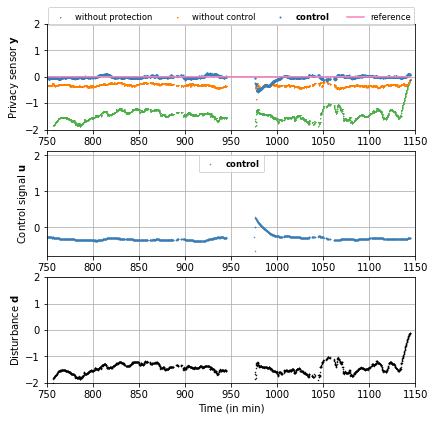

In [52]:
# %matplotlib qt 

result=result_data.copy()
result['Time (in min)']=result_data['elapsedtime']/60
result=result.set_index('Time (in min)').copy()
xlim_min = 750#101980#7.275e6/60#14: 240 ou 750 # 51:8000 # oilrag: 0 # abboip:0
xlim_max = 1150#102050#7.29e6/60#14: 360 ou 1150 # 51: 9440 # oilrag: 600 # abboip: 800

fig, axes = plt.subplots(nrows=3, ncols=1,  figsize=(6.6,6.6))
# U
#result['u_e-2'].plot(color=CB_color_cycle[1],ax=axes[1],marker="+", markersize=2, linestyle = 'None', fillstyle='none', label='without control')
result['u'].plot(color=CB_color_cycle[0],ax=axes[1],marker=".", markersize=1, linestyle = 'None', fillstyle='none', label='$\mathbf{control}$')
#result['u_PI'].plot(color=CB_color_cycle[2],ax=axes[1],marker=".", markersize=3, linestyle = 'None', fillstyle='none', label='PI')
#result['u_FF'].plot(color=CB_color_cycle[3],ax=axes[1],marker=".", markersize=3, linestyle = 'None', fillstyle='none', label='FF')
axes[1].set_ylabel('Control signal $\mathbf{u}$')
axes[1].grid(True)
#axes[1].set_ylim([-2.5,2.5])
axes[1].set_xlim([xlim_min,xlim_max])
axes[1].legend(ncol=2,loc='upper center', fontsize="small") #'upper left', 'upper right', 'lower left', 'lower right', 'upper center', 'lower center', 'center left', 'center right'
# Y
result['d'].plot(color=CB_color_cycle[2],ax=axes[0],marker="+", markersize=1, linestyle = 'None', label='without protection')
result['y_e-2'].plot(color=CB_color_cycle[1],ax=axes[0],marker="+", markersize=1, linestyle = 'None', label='without control')
result['y'].plot(color=CB_color_cycle[0],ax=axes[0],marker=".", markersize=2, linestyle = 'None', label='$\mathbf{control}$')
result['y_sp'].plot(color=CB_color_cycle[3],ax=axes[0],marker="", linewidth=1.5, linestyle = '-', label='reference')
#result['y_model-nl'].plot(color=CB_color_cycle[1],ax=axes[0],marker="", markersize=3, linestyle = '-')
axes[0].set_ylabel('Privacy sensor $\mathbf{y}$')
axes[0].grid(True)
axes[0].set_ylim([-2,2])
axes[0].set_xlim([xlim_min,xlim_max])
axes[0].legend(ncol=4,loc='upper center', bbox_to_anchor=(0.5, 1.2), fontsize="small")
# D
result['d'].plot(color='black',ax=axes[2],marker=".", markersize=1, linestyle = 'None')
axes[2].set_ylabel('Disturbance $\mathbf{d}$')
axes[2].grid(True)
axes[2].set_ylim([-2,2])
axes[2].set_xlim([xlim_min,xlim_max])
#plt.savefig('modeling_with_model_'+eps_modeling_mode+'_'+user+'.pdf')
#plt.savefig('control_'+controller+'_reference_'+reference_mode+'_'+user+'_seed_'+str(seed)+'.pdf')

### Utility Evaluation

In [53]:
print('Spatial distortion - median : '+str(np.median(result['spatial-distortion']))+' m')
print('Spatial distortion - 90th percentile: '+str(np.percentile(result['spatial-distortion'],90))+' m')
print('Static Spatial distortion - median : '+str(np.median(result['spatial-distortion-static']))+' m')
print('Static Spatial distortion - 90th percentile: '+str(np.percentile(result['spatial-distortion-static'],90))+' m')
print('Service Utility - Navigation Lyon: '+str(100*np.mean(result_data['serviceutil_NavLyon']))+' %')
print('Service Utility - Navigation SF: '+str(100*np.mean(result_data['serviceutil_NavSF']))+' %')
print('Service Utility - Venue Finder: '+str(100*np.mean(result_data['serviceutil_VenueFinder']))+' %')
print('Service Utility - Weather forcast: '+str(100*np.mean(result_data['serviceutil_Weather']))+' %')
print('Static Service Utility - Navigation Lyon: '+str(100*np.mean(result_data['serviceutil-static_NavLyon']))+' %')
print('Static Service Utility - Navigation SF: '+str(100*np.mean(result_data['serviceutil-static_NavSF']))+' %')
print('Static Service Utility - Venue Finder: '+str(100*np.mean(result_data['serviceutil-static_VenueFinder']))+' %')
print('Static Service Utility - Weather forcast: '+str(100*np.mean(result_data['serviceutil-static_Weather']))+' %')

Spatial distortion - median : 313.43971314527664 m
Spatial distortion - 90th percentile: 780.5663509582979 m
Static Spatial distortion - median : 165.7893722564381 m
Static Spatial distortion - 90th percentile: 381.8113835692679 m
Service Utility - Navigation Lyon: 0.4763967085318319 %
Service Utility - Navigation SF: 9.484625378951927 %
Service Utility - Venue Finder: 95.71242962321351 %
Service Utility - Weather forcast: 100.0 %
Static Service Utility - Navigation Lyon: 0.25985275010827197 %
Static Service Utility - Navigation SF: 28.453876136855783 %
Static Service Utility - Venue Finder: 99.91338241663058 %
Static Service Utility - Weather forcast: 100.0 %
